载入数据

In [2]:
from mxnet import image
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxTarget
from mxnet.contrib.ndarray import MultiBoxPrior

In [3]:
batch_size = 16
rgb_mean = nd.array([123, 117, 104])
img_height = 200
img_width = 428

def get_iterators(img_height, img_width, batch_size):
    class_names = ['car']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, img_height, img_width),
        path_imgrec='image_train.rec',
        path_imgidx='image_train.idx',
        shuffle=True,
        mean=True)
    val_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, img_width, img_height),
        path_imgrec='image_val.rec',
        shuffle=False,
        mean=True)
    return train_iter, val_iter, class_names, num_class

In [4]:
train_data, test_data, class_names, num_class = get_iterators(img_height, img_width, batch_size)

In [5]:
batch =train_data.next()

查看训练集中图片与label对应是否正确：

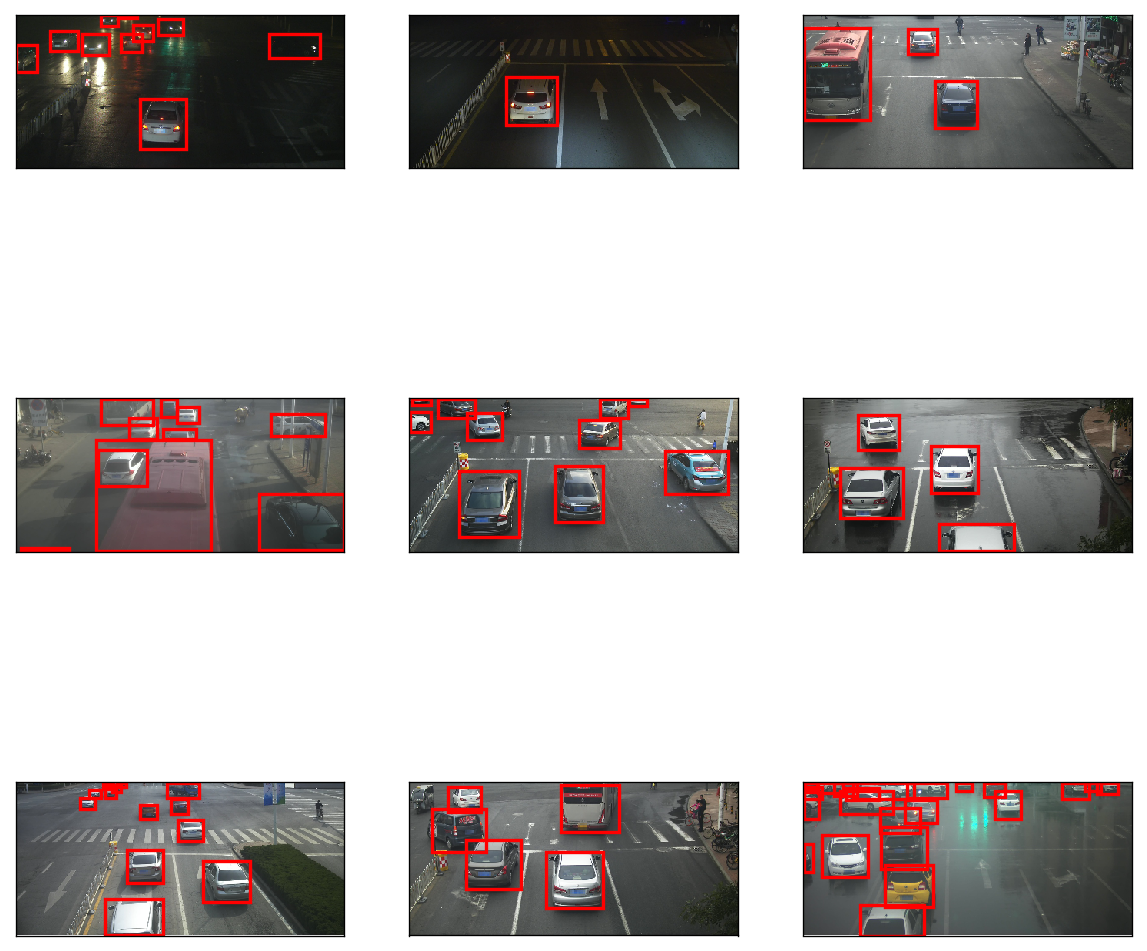

In [6]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
from matplotlib import pyplot as plt
rgb_mean = nd.array([123, 117, 104])

def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), box[2]-box[0], box[3]-box[1],
        fill=False, edgecolor=color, linewidth=linewidth)

_, figs = plt.subplots(3, 3, figsize=(12,12))
for i in range(3):
    for j in range(3):        
        img, labels = batch.data[0][3*i+j], batch.label[0][3*i+j]
        # (3L, 256L, 256L) => (256L, 256L, 3L)
        img = img.transpose((1, 2, 0)) + rgb_mean
        img = img.clip(0,255).asnumpy()/255
        fig = figs[i][j]
        fig.imshow(img)
        for label in labels:
            label[1] = label[1] * img_width
            label[2] = label[2] * img_height
            label[3] = label[3] * img_width
            label[4] = label[4] * img_height
            rect = box_to_rect(label[1:5],'red',2)
            fig.add_patch(rect)                    
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
plt.show()

In [7]:
#预测物体类别
from mxnet.gluon import nn
def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

#预测边框
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

#减半模块
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

#展平y
def flatten_prediction(pred):
    return pred.transpose(axes=(0,2,3,1)).flatten()

#合并y
def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

In [8]:
#主体网络，用于从原始图片提取特征，识别物体的模型在这里做好
#def body():
    #out = nn.HybridSequential()
    #for nfilters in [16, 32, 64]:
        #out.add(down_sample(nfilters)) #conv-bn-activation-Maxpool
    #return out

def body():
    out = nn.HybridSequential()
    out.add(nn.Conv2D(32, 3, strides=1, padding=1))
    out.add(nn.BatchNorm(in_channels=32))
    out.add(nn.Activation('relu'))
    out.add(nn.Conv2D(32, 3, strides=1, padding=1))
    out.add(nn.BatchNorm(in_channels=32))
    out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    
    out.add(nn.Conv2D(64, 3, strides=1, padding=1))
    out.add(nn.BatchNorm(in_channels=64))
    out.add(nn.Activation('relu'))
    out.add(nn.Conv2D(64, 3, strides=1, padding=1))
    out.add(nn.BatchNorm(in_channels=64))
    out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
            
    out.add(nn.Conv2D(128, 3, strides=1, padding=1))
    out.add(nn.BatchNorm(in_channels=128))
    out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out
    
#SSD模型，用于生成物体分类和bbox回归的的网络
def toy_ssd_model(num_anchors, num_classes):
    downsamplers = nn.Sequential()
    for _ in range(3):
        downsamplers.add(down_sample(128))

    class_predictors = nn.Sequential()
    box_predictors = nn.Sequential()
    for _ in range(5):
        class_predictors.add(class_predictor(num_anchors, num_classes))
        box_predictors.add(box_predictor(num_anchors))

    model = nn.Sequential()
    model.add(body(), downsamplers, class_predictors, box_predictors) #主体网络，三个减半模块，以及五个物体类别和边框预测模块
    return model

#用于计算的前向传播
def toy_ssd_forward(x, model, sizes, ratios, verbose=False):
    body, downsamplers, class_predictors, box_predictors = model
    anchors, class_preds, box_preds = [], [], []
    # feature extraction
    x = body(x)
    for i in range(5):
        # predict
        anchors.append(MultiBoxPrior(
            x, sizes=sizes[i], ratios=ratios[i]))
        class_preds.append(
            flatten_prediction(class_predictors[i](x)))
        box_preds.append(
            flatten_prediction(box_predictors[i](x)))
        if verbose:
            print('Predict scale', i, x.shape, 'with',
                  anchors[-1].shape[1], 'anchors')
        # down sample
        if i < 3:
            x = downsamplers[i](x)
        elif i == 3:
            x = nd.Pooling(
                x, global_pool=True, pool_type='max',
                kernel=(x.shape[2], x.shape[3]))
    # concat data
    return (concat_predictions(anchors),
            concat_predictions(class_preds),
            concat_predictions(box_preds))

**完整的模型**

In [9]:
net = body()
net

HybridSequential(
  (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
  (2): Activation(relu)
  (3): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
  (5): Activation(relu)
  (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (7): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
  (9): Activation(relu)
  (10): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
  (12): Activation(relu)
  (13): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mo

In [10]:
from mxnet import gluon
class ToySSD(gluon.Block):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes and ratios for 5 feature scales
        self.sizes = [[.2,.272], [.37,.447], [.54,.619],
                      [.71,.79], [.88,.961]]
        self.ratios = [[1,2,.5]]*5
        self.num_classes = num_classes
        self.verbose = verbose
        num_anchors = len(self.sizes[0]) + len(self.ratios[0]) - 1
        # use name_scope to guard the names
        with self.name_scope():
            self.model = toy_ssd_model(num_anchors, num_classes)

    def forward(self, x):
        anchors, class_preds, box_preds = toy_ssd_forward(
            x, self.model, self.sizes, self.ratios,
            verbose=self.verbose)
        # it is better to have class predictions reshaped for softmax computation
        class_preds = class_preds.reshape(shape=(0, -1, self.num_classes+1))
        return anchors, class_preds, box_preds

In [11]:
net = ToySSD(num_classes=1, verbose=True)
net.initialize()
x = batch.data[0][0:1]
print('Input:', x.shape)
anchors, class_preds, box_preds = net(x)
print('Output achors:', anchors.shape)
print('Output class predictions:', class_preds.shape)
print('Output box predictions:', box_preds.shape)

Input: (1, 3, 200, 428)
Predict scale 0 (1, 128, 25, 53) with 5300 anchors
Predict scale 1 (1, 128, 12, 26) with 1248 anchors
Predict scale 2 (1, 128, 6, 13) with 312 anchors
Predict scale 3 (1, 128, 3, 6) with 72 anchors
Predict scale 4 (1, 128, 1, 1) with 4 anchors
Output achors: (1, 6936, 4)
Output class predictions: (1, 6936, 2)
Output box predictions: (1, 27744)


损失函数

In [12]:
from mxnet.contrib.ndarray import MultiBoxTarget
def training_targets(anchors, class_preds, labels):
    class_preds = class_preds.transpose(axes=(0,2,1))
    return MultiBoxTarget(anchors, labels, class_preds)

class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pj = output.pick(label, axis=self._axis, keepdims=True)
        loss = - self._alpha * ((1 - pj) ** self._gamma) * pj.log()
        return loss.mean(axis=self._batch_axis, exclude=True)
    
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return loss.mean(self._batch_axis, exclude=True)

cls_loss = FocalLoss()
box_loss = SmoothL1Loss()

评估测量

In [13]:
from mxnet import metric

cls_metric = metric.Accuracy()
box_metric = metric.MAE()

初始化模型和训练器

In [14]:
from mxnet import init
from mxnet import gpu

ctx = gpu(0)
# the CUDA implementation requres each image has at least 3 lables.
# Padd two -1 labels for each instance
#train_data.reshape(label_shape=(3, 5))
train_data = test_data.sync_label_shape(train_data)

net = ToySSD(num_class)
net.initialize(init.Xavier(magnitude=2), ctx=ctx)
#net.initialize(init.Xavier(magnitude=2))
trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

训练模型

In [1]:
import time
from mxnet import autograd
for epoch in range(30):
    # reset data iterators and metrics
    train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    for i, batch in enumerate(train_data):
        x = batch.data[0].as_in_context(ctx)
        y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            anchors, class_preds, box_preds = net(x)
            box_target, box_mask, cls_target = training_targets(
                anchors, class_preds, y)
            # losses
            loss1 = cls_loss(class_preds, cls_target)
            loss2 = box_loss(box_preds, box_target, box_mask)
            loss = loss1 + loss2
        loss.backward()
        trainer.step(batch_size)
        # update metrics
        cls_metric.update([cls_target], [class_preds.transpose((0,2,1))])
        box_metric.update([box_target], [box_preds * box_mask])

    print('Epoch %2d, train %s %.2f, %s %.5f, time %.1f sec' % (
        epoch, *cls_metric.get(), *box_metric.get(), time.time()-tic
    ))

KeyboardInterrupt: 

In [ ]:
filename = "improve_model_mae0.00xxx.params"
net.save_params(filename)

In [15]:
net.load_params("improve_model_mae0.00657.params")
#net.load_params("improve_model_mae0.00725.params")

In [16]:
def process_image(fname):
    with open(fname, 'rb') as f:
        im = image.imdecode(f.read())
    # resize to data_shape
    data = image.imresize(im, img_height, img_width)
    # minus rgb mean
    data = data.astype('float32') - rgb_mean
    # convert to batch x channel x height xwidth
    return data.transpose((2,0,1)).expand_dims(axis=0), im

from mxnet.contrib.ndarray import MultiBoxDetection

def predict(x):
    anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
    cls_probs = nd.SoftmaxActivation(
        cls_preds.transpose((0,2,1)), mode='channel')

    return MultiBoxDetection(cls_probs, box_preds, anchors,
                             force_suppress=True, clip=False)

In [ ]:
#x, im = process_image('00e0c35f-a9bf-4250-8467-25dc89af608c.jpg')  #原始尺寸图片
#out = predict(x)

In [ ]:
x, im = process_image('test_car2.jpg')  #512×512图片
out = predict(x)

In [ ]:
out

In [ ]:
import numpy as np
mpl.rcParams['figure.figsize'] = (6,6)
colors = ['blue', 'green', 'red', 'black', 'magenta']

def display(im, out, threshold=0.5):
    plt.imshow(im.asnumpy())
    for row in out:
        row = row.asnumpy()
        class_id, score = int(row[0]), row[1]
        if class_id < 0 or score < threshold:
            continue
        color = colors[class_id%len(colors)]
        box = row[2:6] * np.array([im.shape[0],im.shape[1]]*2)
        rect = box_to_rect(nd.array(box), color, 2)
        plt.gca().add_patch(rect)

        text = class_names[class_id]
        plt.gca().text(box[0], box[1],
                       '{:s} {:.2f}'.format(text, score),
                       bbox=dict(facecolor=color, alpha=0.5),
                       fontsize=10, color='white')
    plt.show()

display(im, out[0], threshold=0.5)

**可以继续提高准确率的想法：**

- 主体网络body可以用预训练模型，暂时没有思路，原因是预训练模型如VGG19最后的卷积层feature map很小，可以生成的anchor box也很少。
- anchor box生成的尺寸和宽高比可以修改

**有疑惑点的地方：**

- 模型的训练集图片为1069×500，之前的情况感觉得用512×512的图片来预测并绘图，此处需搞清楚为什么
- MultiBoxPrior函数暂时是个黑盒子，需要搞清楚它是如何生成的anchor box，以及尺寸不是正方形的图片该用何种的size和ratio。

下面生成提交文件，生成的是txt文件，改后缀为csv即可。

In [22]:
import os #处理路径
import numpy as np
from tqdm import tqdm

path = 'D:/test_a'
imgs = os.listdir(path)

import pandas as pd
threshold = 0.55

In [23]:
a=[]
b=[]
for img in tqdm(imgs):
    c = []
    x, im = process_image('D:/test_a/{}'.format(img))
    out = predict(x)
    out = np.resize(out.asnumpy(),(1648,6))
    for row in out:
        class_id, score = int(row[0]), row[1]
        if class_id < 0 or score < threshold:
            continue
            
        Xmin = row[2]
        ymin = row[3]
        Xmax = row[4]
        ymax = row[5]
        
        if Xmin < 0:
            Xmin = 0
        if ymin < 0:
            ymin = 0
        if Xmax > 1:
            Xmax = 1
        if ymax > 1:
            ymax = 1
            
        c.append(str(Xmin*1069) + '_' + str(ymin*500) + '_' + str((Xmax - Xmin)*1069) + '_' + str((ymax - ymin)*500))
    b.append(c)
    a.append(img)

100%|████████████████████████████████████████████████████████████████████████████| 36000/36000 [44:34<00:00, 13.46it/s]


In [25]:
with open('submit2.txt', 'w') as f:
    f.write('name,coordinate' + '\n')
    
    for i in range(len(b)):
        f.write(a[i]+',')
        if(b[i]==[]):
            f.write(''+ '\n')
        else:
            for j in range(len(b[i])):
                if j == len(b[i])-1:
                    f.write(b[i][j] + '\n')
                else:
                    f.write(b[i][j]+';')
f.close()